In [112]:
# !pip install tensorflow
# !pip install opencv-python
# !pip install --upgrade --user pip
# !pip install google.colab
# !pip install itables
# !pip install dill
# !pip install visualkeras
# !pip install pydot
# !pip install --upgrade Pillow

In [113]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
# import json
# import birds_utils.BIRDS
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau,History,CSVLogger


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

# System libraries
from pathlib import Path
import os.path
# import random
# import pickle
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
# import itertools
# import dill
# import copy

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# from PIL import ImageFont
# import visualkeras
# import time

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

# Run configuration

In [114]:
# principle parameters
project_dir = '.'
BASE_PATH = project_dir+'/models/'
data_path = project_dir+'/data/'
# tfrecord_file = data_path+'dataset.tfrecord'
# tfrecord_files = 'path/to/your/tfrecord_file.tfrecord'  # Update with your TFRecord file path
csv_file_path = Path(str(data_path) + '/image_df_full.csv')
RECREATE_CSV = False  # Set to True to always recreate the CSV, False to create only if it does not exist
overwrite_tfrecords = False # Global variable indicating whether to overwrite TFRecords
BATCH_SIZE = 32 # size of batch (The ImageDataGenerator objects generate batches of tensor image data with real-time data augmentation)
TARGET_SIZE = (224, 224)    # size of pictures (used by the ImageDataGenerator objects)
N_LABELS = 2 # 'all'    # number of lables for analysis ('all will keep all labels)
N_EPOCHS = 100 # number of epochs for the traning NN
N_SAMPLES_PER_LABEL = 'all' # number of sampels per label that are kept for valing ('all' will keep all samples)
N_EPOCHS_PATIENCE = 5
AUGMENTATON = False

GRID_SEARCH = False  
RANDOM_STATE = 50

if (AUGMENTATON):
    RUN_NAME = f'aug_N_LAB_{N_LABELS}'
else:
    RUN_NAME = f'no_aug_N_LAB_{N_LABELS}'
label_count_thresh = 50
fig_width = 8

MODELS_PATH = f'{BASE_PATH}{RUN_NAME}/'
if (not os.path.exists(MODELS_PATH)):
    os.makedirs(MODELS_PATH)
    print(f'MODELS_PATH {MODELS_PATH} was created')

## Import helping functions

In [115]:
import birds_utils as birds

# Load and prepare data

## load data

In [116]:
# Check if the CSV file exists and the RECREATE_CSV flag
if RECREATE_CSV or not os.path.exists(csv_file_path):
    # Import the module with the load_data function (assumes birds_utils.py is in the project directory)
    import birds_utils as birds

    # Load data, drop duplicates, and shuffle
    image_df_full = birds.load_data(project_dir).drop_duplicates()
    image_df_full = image_df_full.sample(frac=1, random_state=RANDOM_STATE)

    # Save the dataframe as a CSV file
    image_df_full.to_csv(csv_file_path)

# Load the dataframe from the CSV file
image_df_full = pd.read_csv(csv_file_path)

# Drop the extra index column that pandas creates
image_df_full.drop('Unnamed: 0', axis=1, inplace=True)
# image_df_full

In [117]:
TOTAL_LABELS = len(image_df_full['label'].unique())
TOTAL_LABELS

526

In [118]:
# Create a mapping from labels to unique integers
label_to_id = {label: idx for idx, label in enumerate(image_df_full['label'].unique())}
id_to_label = {idx: label for label, idx in label_to_id.items()}
# label_to_id, id_to_label

In [119]:
# Map the labels to ids
image_df_full['label_id'] = image_df_full['label'].map(label_to_id)

# image_df_full

# EDA

In [120]:
# birds.plot_labels_count(image_df_full)

In [121]:
# filter out all the lables with less than label_count_thresh
boolean_vec = image_df_full.groupby('label').count()['Filepath'].values>=label_count_thresh
labels_to_keep = image_df_full.groupby('label').count()[boolean_vec]

# filter out LOONEY BIRDS (as it contains faces and not birds)
excluded_labels = ['LOONEY BIRDS']  # Add labels you want to exclude
labels_to_keep = labels_to_keep.drop(excluded_labels, errors='ignore')

image_df = birds.filter_df(image_df_full,labels=list(labels_to_keep.index))
# remove 'other' images
image_df = birds.remove_other_images(image_df)

In [122]:
if (N_LABELS=='all'):
    N_LABELS = len(birds.get_labels(image_df))
    
lables = list(birds.get_labels(image_df)[0:N_LABELS])
image_df = birds.filter_df(image_df,labels=lables)
image_df = birds.filter_df(image_df,N_samples_per_label=N_SAMPLES_PER_LABEL)

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
labels = image_df['label'].tolist() # Make sure this is your training data labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
lables

['LITTLE AUK', 'GO AWAY BIRD']

# Data Splitting into 3 ImageDataGenerators


In [123]:
from sklearn.model_selection import train_test_split

# Splitting the DataFrame
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=RANDOM_STATE, stratify=image_df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=RANDOM_STATE, stratify=train_df['label'])

### Function to create a TFRecords

In [124]:
# Function to create a TFRecord
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _string_feature(value):
    """Returns a bytes_list from a string."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(value)]))

def _float_feature_list(values):
    """Returns a float_list from a list of float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=values))

def create_tfrecord(df_row):
    # Extracting data from the DataFrame row
    Filepath = df_row['Filepath']
    label_id = df_row['label_id']
    index = df_row.name  # Using the DataFrame's index as a unique identifier

    # Reading and processing the image
    image = cv2.imread(Filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # One-hot encode the label
    one_hot_label = tf.one_hot(label_id, depth=N_LABELS).numpy().tolist()

    feature = {
        'image': _bytes_feature(image),
        'label_id': _int64_feature(label_id),
        'one_hot_label': _float_feature_list(one_hot_label),
        'filepath': _string_feature(Filepath),
        'index': _int64_feature(index)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))



# Function to create TFRecord files
def create_tfrecord_files(df, subset_name):
    tfrecord_file_name = f"{data_path}{subset_name}_{N_LABELS}_labels_{RANDOM_STATE}.tfrecord"

    # Check if the file already exists
    if os.path.exists(tfrecord_file_name) and not overwrite_tfrecords:
        print(f"TFRecord file already exists at: {tfrecord_file_name}. Skipping creation.")
        return
    else:
        with tf.io.TFRecordWriter(tfrecord_file_name) as writer:
            for _, row in df.iterrows():
                tf_example = create_tfrecord(row)
                writer.write(tf_example.SerializeToString())
        print(f"TFRecord for {subset_name} created: {tfrecord_file_name}")

# Creating TFRecord files for each subset
create_tfrecord_files(train_df, 'train')
create_tfrecord_files(val_df, 'val')
create_tfrecord_files(test_df, 'test')


TFRecord file already exists at: ./data/train_2_labels_50.tfrecord. Skipping creation.
TFRecord file already exists at: ./data/val_2_labels_50.tfrecord. Skipping creation.
TFRecord file already exists at: ./data/test_2_labels_50.tfrecord. Skipping creation.


### Read from TFRecords

In [125]:
import tensorflow as tf

def parse_tfrecord(tfrecord):
    # Define the feature description for parsing
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label_id': tf.io.FixedLenFeature([], tf.int64),
        'one_hot_label': tf.io.VarLenFeature(tf.float32),
        'filepath': tf.io.FixedLenFeature([], tf.string),
        'index': tf.io.FixedLenFeature([], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above
    example = tf.io.parse_single_example(tfrecord, feature_description)

    # Decode the image
    image = tf.io.decode_jpeg(example['image'])
    # You might want to preprocess the image (e.g., resizing) here

    # Convert one_hot_label from a SparseTensor to a dense tensor
    one_hot_label = tf.sparse.to_dense(example['one_hot_label'])

    return image, one_hot_label

def load_dataset(tfrecord_file):
    # Load the dataset
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

    # Map the parsing function over the dataset
    parsed_dataset = raw_dataset.map(parse_tfrecord)

    return parsed_dataset

# Construct the file names
train_file = f"{data_path}train_{N_LABELS}_labels_{RANDOM_STATE}.tfrecord"
val_file = f"{data_path}val_{N_LABELS}_labels_{RANDOM_STATE}.tfrecord"
test_file = f"{data_path}test_{N_LABELS}_labels_{RANDOM_STATE}.tfrecord"

# Load the datasets
train_ds = load_dataset(train_file)
val_ds = load_dataset(val_file)
test_ds = load_dataset(test_file)

# Further processing (like batching, shuffling, etc.) can be done as needed


### train_generator

In [126]:
def preprocess_image(image, label):
    # Resize the image to the target size
    image = tf.image.resize(image, TARGET_SIZE)
    # Add any additional preprocessing here (e.g., normalization)
    return image, label

# Apply the preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

# Further processing like batching and shuffling
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Saving limited ds copy
train_ds_ltd = train_ds
val_ds_ltd = val_ds
# adding repeat to ds
train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

In [127]:
# for images, labels in train_ds.take(1):
#     print("Train batch - features:", images.shape, "labels:", labels.shape)
# for images, labels in val_ds.take(1):
#     print("Validation batch - features:", images.shape, "labels:", labels.shape)


In [128]:
# small_train_ds = train_ds.take(1)  # Taking only the first batch
# model.fit(small_train_ds, epochs=1, steps_per_epoch=1)


## Check the distribution of the labels in all dfs

In [129]:
# fig = plt.figure

# obj_dic_stack = {}
# obj_dic_stack['test'] = test_obj_dic
# obj_dic_stack['val'] = val_obj_dic
# obj_dic_stack['train'] = train_obj_dic


# label_distribute = pd.DataFrame()
# label_distribute_pre = pd.DataFrame()
# for df_type in obj_dic_stack.keys():
#     label_distribute_pre['p'+'_'+df_type] = obj_dic_stack[df_type]['df'].groupby('label').count().status/obj_dic_stack[df_type]['df'].shape[0]
    
#     if label_distribute.shape[0]==0:
#         label_distribute = label_distribute_pre['p'+'_'+df_type]
    
# label_distribute_pre.plot(y=label_distribute_pre.columns)
# plt.title('label distribution for train, validate and test')
# plt.xticks(rotation=45, fontsize=10)
# # plt.xticks(range(0, len(label_distribute_pre.index), max(len(label_distribute_pre.index) // 10, 1)), label_distribute_pre.index[::max(len(label_distribute_pre.index) // 10, 1)])
    


In [130]:
# craete labels dictionary to be used by apply_model routine
# labels_dic = birds.create_lables_dic(train_obj_dic['images_obj'])


## Define the image augmentation object

## Observing augemented images

In [131]:
# try:
#     birds.plot_images(image_df,idx=[5],n_cols=1,fig_width = 5)

# except:
#     k =1 

idx 29633 does not exist in data frame
idx 29633 does not exist in data frame


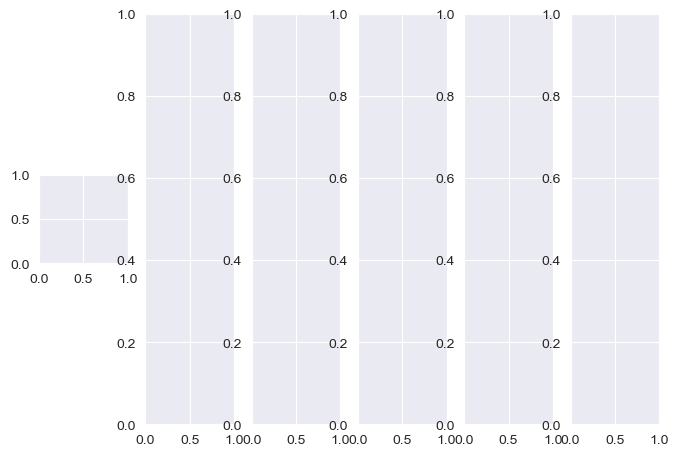

In [132]:
try:
    ind = 3
    img = birds.get_image(image_df,idx=29633)
    import copy


    num_cols=6


    operation_dic = {
                        'RandomContrast':[1.0,1.0],
                        'RandomRotation':[0,180],
                        'RandomTranslation':[0.1,0.5],  
                        'RandomZoom':[0.9,0.9]                   
                    }

    num_rows = len(operation_dic.keys())
    fig_width = 8


    for opration in list(operation_dic.keys()):
        val_vec = np.linspace(operation_dic[opration][0],operation_dic[opration][1],num_cols)
        fig, axes = plt.subplots(1, num_cols, figsize=(fig_width, fig_width*num_rows/num_cols) )
        c=0
        for ind, ax in enumerate(axes.flat):
            img = copy.deepcopy(birds.get_image(image_df[:],idx=29633))
            if (c==0):
                ax.imshow(img)
                ax.axis('off')
                c=1
                continue

            if (opration=='RandomContrast'):
                augment = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows])
                ])
            elif (opration=='RandomRotation'):
                augment = tf.keras.Sequential([
                    # layers.experimental.preprocessing.RandomRotation([val_vec[ind%num_rows],val_vec[ind%num_rows]])
                    layers.experimental.preprocessing.RandomRotation(factor=(0,val_vec[ind%num_rows]))
                ])
                
            elif (opration=='RandomTranslation'):
                augment = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomTranslation(height_factor = val_vec[ind%num_rows],width_factor = val_vec[ind%num_rows])
                ])

            elif (opration=='RandomZoom'):
                augment = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomZoom(val_vec[ind%num_rows])
                ])



            # Example: Replace this line with your image loading logic
            img_array = np.expand_dims(img, axis=0)

            augmented_image = augment(np.expand_dims(img, 0)).numpy().squeeze() / 255

            # Display the augmented image in the current subplot
            ax.imshow(augmented_image)
            ax.axis('off')

            # augment = tf.keras.Sequential([
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),                
            #     ])


        plt.show()

except:
        k = 1


# Model assembly

## Image Augemntation

In [133]:
operation_dic = {
                    'RandomContrast':1.0,
                    'RandomRotation':180,
                    'RandomTranslation':0.5,  
                    'RandomZoom':0.9, 
                    'RandomFlip':'horizontal'                  
                }

if (AUGMENTATON):
  RUN_NAME = f'Translation'

augment = tf.keras.Sequential([
  # layers.experimental.preprocessing.Resizing(224,224),
  # layers.experimental.preprocessing.Rescaling(1./255),
#   layers.experimental.preprocessing.RandomFlip(operation_dic['RandomFlip']),
  # layers.experimental.preprocessing.RandomRotation(operation_dic['RandomRotation']),
  layers.experimental.preprocessing.RandomTranslation(height_factor = operation_dic['RandomTranslation'] ,width_factor = operation_dic['RandomTranslation']),
  # layers.experimental.preprocessing.RandomTranslation(height_factor = val_vec[ind%num_rows],width_factor = val_vec[ind%num_rows])

  # layers.experimental.preprocessing.RandomZoom(operation_dic['RandomZoom']),
#   layers.experimental.preprocessing.RandomContrast(operation_dic['RandomContrast']),
])

## load EfficientNetB0 pre-process NN

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from birds_utils import train_model  # Import the train_model function

# Assuming all required variables (TARGET_SIZE, N_LABELS, etc.) are defined

# Build the Model with EfficientNetB0
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    Dense(1024, activation='relu'),
    Dense(N_LABELS, activation='softmax')  # N_LABELS is the number of classes
])

# Compile the Model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare parameters and datasets for train_model function
train_obj_dic = {
    'images_obj': train_ds,
    'df': train_df,
    'name': 'train' 
}

train_obj_dic_ltd = {
    'images_obj': train_ds_ltd,
    'df': train_df,
    'name': 'train' 
}

val_obj_dic = {
    'images_obj': val_ds,
    'df': val_df,
    'name': 'validation'
}

val_obj_dic_ltd = {
    'images_obj': val_ds_ltd,
    'df': val_df,
    'name': 'validation'
}

test_obj_dic = {
    'images_obj': test_ds,
    'df': test_df,
    'name': 'test'
}


params = {'N_epochs': N_EPOCHS, 'N_labels': N_LABELS, 'models_path': MODELS_PATH, 'N_epochs_patitence': N_EPOCHS_PATIENCE}
params

{'N_epochs': 100,
 'N_labels': 2,
 'models_path': './models/no_aug_N_LAB_2/',
 'N_epochs_patitence': 5}

In [135]:
import visualkeras
color_map = birds.create_color_map

# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False
# font_size = 100
scale_xy=3

# Adjust the font size
# font = ImageFont.truetype("arial.ttf", font_size)


# visualkeras.layered_view(pretrained_model, legend=True, font=font, to_file='model.png', scale_xy=scale_xy, color_map=birds.create_color_map())

# Model training and evaluation on a grid search 

## Apply grid search

In [136]:
for images, labels in train_obj_dic['images_obj'].take(1):
    print("Images shape:", images.shape)  # Expected: (batch_size, height, width, channels)
    print("Labels shape:", labels.shape)  # Expected: (batch_size, num_classes)


Images shape: (32, 224, 224, 3)
Labels shape: (32, 2)


In [137]:
type(train_ds)

tensorflow.python.data.ops.repeat_op._RepeatDataset

In [138]:
tf.data.experimental.cardinality(train_ds).numpy()

-1

In [139]:
# # Enabling eager execution for debugging
# tf.config.run_functions_eagerly(True)

# # Before training, check a few batches from the dataset
# for x, y in train_obj_dic['images_obj'].take(2):
#     print("Train batch - features:", x.numpy().shape, "labels:", y.numpy().shape)

# for x, y in val_obj_dic['images_obj'].take(2):
#     print("Validation batch - features:", x.numpy().shape, "labels:", y.numpy().shape)

# # Proceed with model compilation and training
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
# model, history = birds.train_model(model, MODELS_PATH, train_obj_dic, val_obj_dic, params, BATCH_SIZE)


In [140]:
params_dic = {}
if (GRID_SEARCH):
    params_dic['dense1_size'] = [64,128,256]
    params_dic['dense2_size'] = [64,128,256]
else:
    params_dic['dense1_size'] = [128]
    params_dic['dense2_size'] = [256]

params_dic['N_epochs_patitence'] = [N_EPOCHS_PATIENCE]
params_dic['N_epochs'] = [N_EPOCHS] 
params_dic['N_labels'] = [N_LABELS]
selected_indices = []  # Note: Python indexing is zero-based
params_list = birds.get_params_permutations(params_dic)

if (len(selected_indices) == 0):
    selected_permutations = params_list
else:
    selected_permutations = [params_list[i] for i in selected_indices]
for i in range(len(selected_permutations)):
    params = selected_permutations[i]
    model = birds.create_model(pretrained_model,params,visualize_model=False,AUGMENTATON = AUGMENTATON)
    model,history = birds.train_model(model,MODELS_PATH,train_obj_dic,val_obj_dic,params, BATCH_SIZE)

    # evaluate the model on all 3 data segments.
    # This can be done on all the iterations, but takes time.
    # As the decision on the best configuraion is done based on the histories' observations, this is normaly marked out, and done later on
    # on the chosen configuration
    # obj_dic_stack = birds.get_obj_dic_stack(model,MODELS_PATH,train_obj_dic,val_obj_dic,test_obj_dic,params,plot_report=False)

    # # plot score peformance for all 3 datasets
    # birds.plot_obj_dic_stack_score(obj_dic_stack,score='f1-score')

-----------------
  create model
-----------------
--------------------------------
  train model
--------------------------------
./models/no_aug_N_LAB_2_128_256_5_100_2/check_point.h5
loading no_aug_N_LAB_2_128_256_5_100_2 and related history


## choosing the optimized configuration

### compare runs in terms of number of ephocs and performance

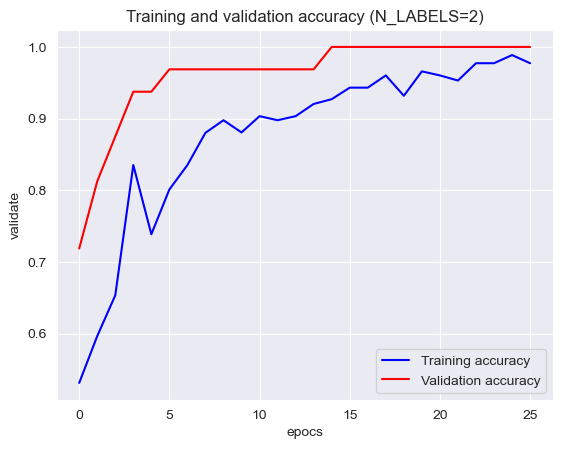

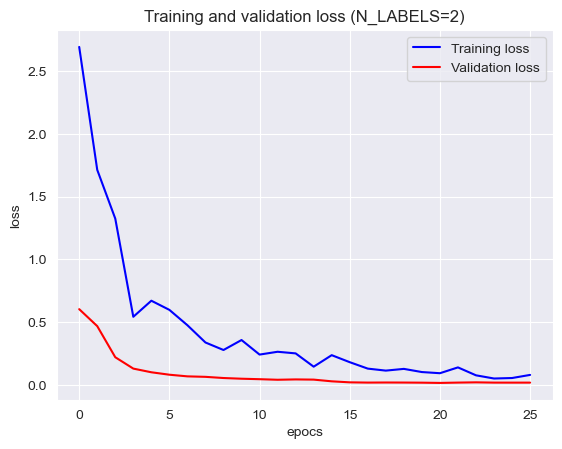

In [141]:
# get all the history file names in a list

# if (GRID_SEARCH):
subfolders = birds.get_filtered_subfolders (BASE_PATH,f'LABELS_{N_LABELS}_')
history_file_names = []
for subfolder in subfolders:
    file_name = birds.get_filtered_files(BASE_PATH+subfolder,'history',full_path = 'True')
    history_file_names.append(file_name[0])

if (len(history_file_names)>1):
    birds.plot_training_history(history_file_names,plot_str=f' (N_LABELS={N_LABELS})')
else:
    birds.plot_history_single_run(history,plot_str=f' (N_LABELS={N_LABELS})')

# except:
#     print('could not plot run history. Possible reason is that no runs for this configuration')


# Deep observation of the chosen model

In [142]:
# plot only the last model of the grid search
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model Evaluation

In [143]:
def apply_model(model,labels_dic,obj_dic,plot_report=True,evaluate=True):

    name = obj_dic['name']
    print('--------------------------------')
    print(f'  apply model on {name}')
    print('--------------------------------')

# apply the model  
    pred_proba = model.predict(obj_dic['images_obj'])
    proba = np.max(pred_proba,axis=1)
    max_proba_ind = np.argmax(pred_proba,axis=1)
    # print(max_proba_ind)
    pred = [labels_dic[k] for k in max_proba_ind]

    obj_dic['df']['predicted_label'] = pred
    obj_dic['df']['status'] = obj_dic['df']['predicted_label']==obj_dic['df']['label']
    obj_dic['df']['proba'] = proba

    if (evaluate):
        results = model.evaluate(obj_dic['images_obj'], verbose=0)
        obj_dic['accuracy'] = results[1]
        obj_dic['loss'] = results[0]

        print ('\n')    
        print ('--------------------------------')
        print (f"    results for {obj_dic['name']}")
        print ('--------------------------------')
        print(f"{obj_dic['name']} Loss: {results[0]:.5f}")
        print(f"{obj_dic['name']} Accuracy: {(results[1] * 100):.2f}%")


    obj_dic['pred_proba'] = pred_proba


    obj_dic['classification_report'] = get_classification_report(obj_dic['df']['label'], obj_dic['df']['predicted_label'])


    # add accuracy
    accuracy_df = calculate_accuracy_per_label(obj_dic['df'], label_col='label', predicted_col='predicted_label')

    obj_dic['classification_report'] = obj_dic['classification_report'].merge(accuracy_df, left_index=True, right_index=True)


    # plot if desired
    if (plot_report):
        plot_columns = list(obj_dic['classification_report'].columns)
        plot_columns.remove('support')
        name = obj_dic['name']
        obj_dic['classification_report'][plot_columns].plot(rot=45,title=f'{name}:classification report')


    print(obj_dic['classification_report'] )

    return obj_dic

In [144]:
# def create_labels_dic(train_df):
#     # Get unique labels from the specified column and sort them to ensure consistent ordering
#     unique_labels = sorted(train_df['label'].unique())
#     # labels_dic = {label: idx for idx, label in enumerate(unique_labels)}
#     # labels_dic = dict((v) for v in unique_labels)
#     labels_dic = {}
#     for idx, label in enumerate(unique_labels):
#         labels_dic[idx] = label
#     return labels_dic

In [145]:
# labels_dic=create_labels_dic(train_df)
# plot_report=False

In [146]:
# labels_dic

In [147]:
# birds.create_labels_dic(train_df)
# test_obj_dic = apply_model(model,labels_dic,test_obj_dic,plot_report=plot_report)


--------------------------------
  apply model on test
--------------------------------


3/3 [==============================] - 2s 293ms/step


--------------------------------
    results for test
--------------------------------
test Loss: 0.01520
test Accuracy: 100.00%
              precision  recall  f1-score  support  accuracy
GO AWAY BIRD        0.0     0.0       0.0     29.0       0.0
LITTLE AUK          0.0     0.0       0.0     37.0       0.0
--------------------------------
  apply model on train
--------------------------------
7/7 [==============================] - 2s 326ms/step


--------------------------------
    results for train
--------------------------------
train Loss: 0.00275
train Accuracy: 100.00%
              precision    recall  f1-score  support  accuracy
GO AWAY BIRD   0.457627  0.600000  0.519231     90.0  0.600000
LITTLE AUK     0.600000  0.457627  0.519231    118.0  0.457627
--------------------------------
  apply model on validation
--------------------------------
2/2 [==============================] - 1s 264ms/step


-------------------

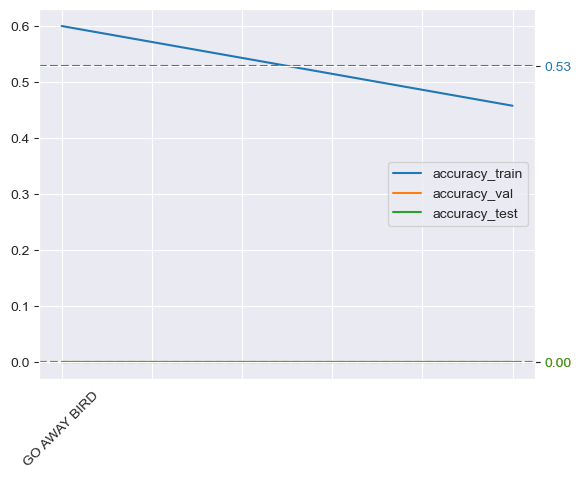

In [148]:
# creat (or load) the obj_dic_stack including all data for model performance analysis
obj_dic_stack_file_name = f'{MODELS_PATH}{RUN_NAME}_obj_dic_stack.pkl'
obj_dic_stack = birds.get_obj_dic_stack(model,MODELS_PATH,train_obj_dic_ltd,val_obj_dic_ltd,test_obj_dic,params,plot_report=False)

# plot score performance for all 3 datasets
birds.plot_obj_dic_stack_score(obj_dic_stack,score='accuracy')

## look at false detections

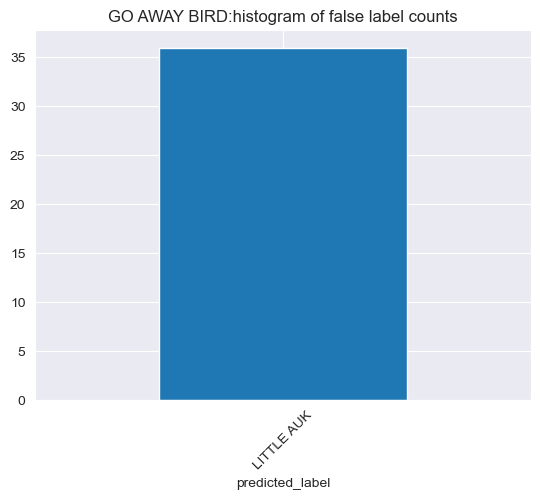

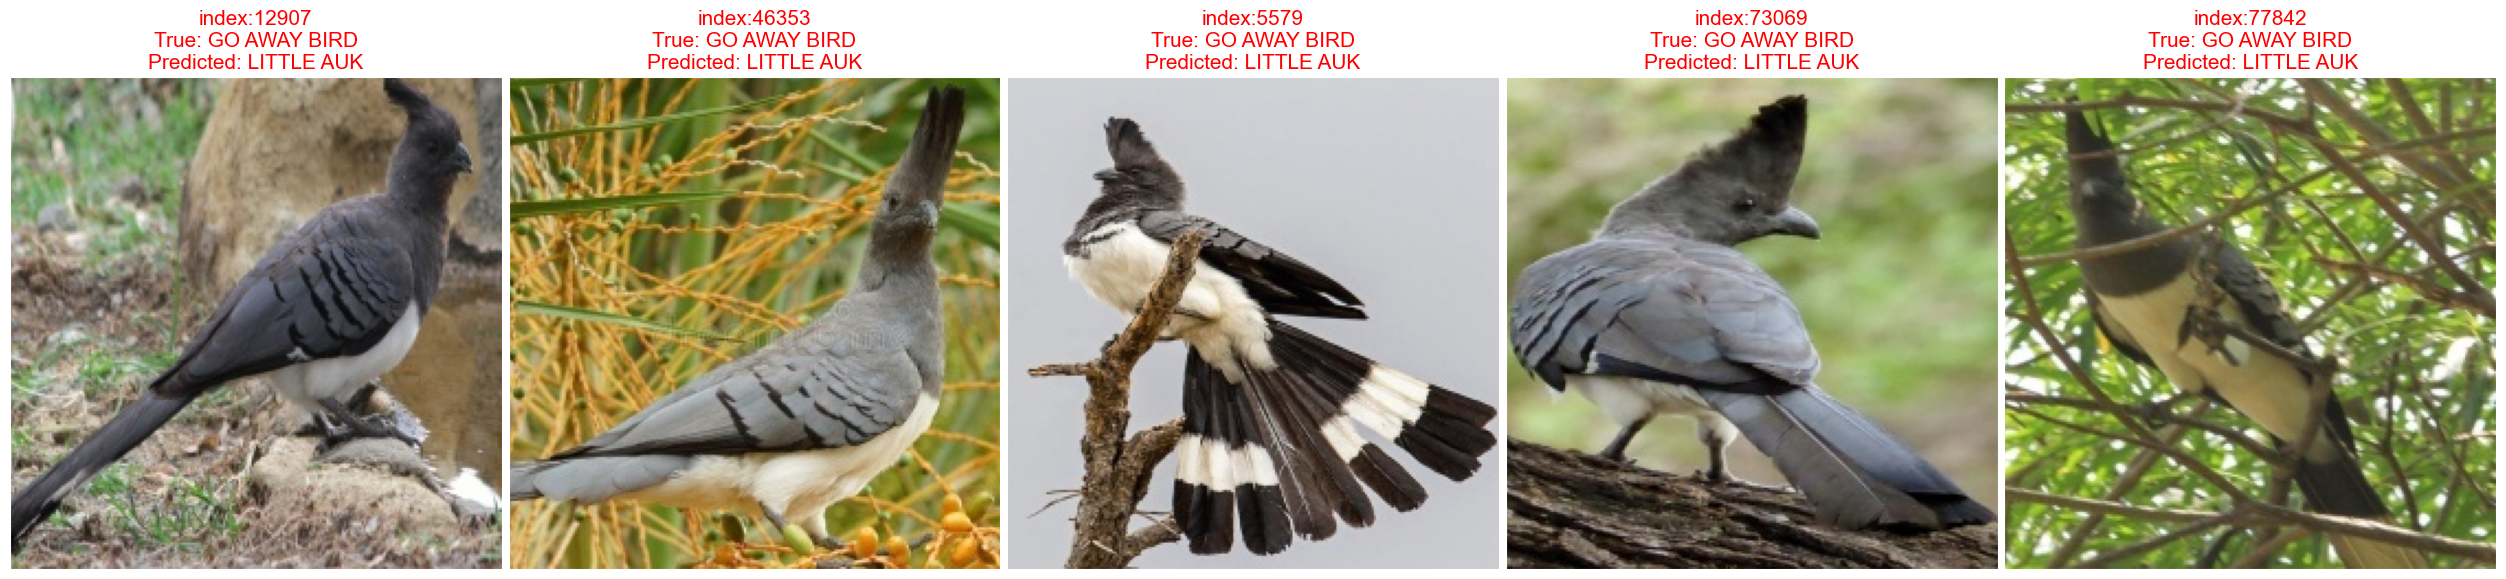

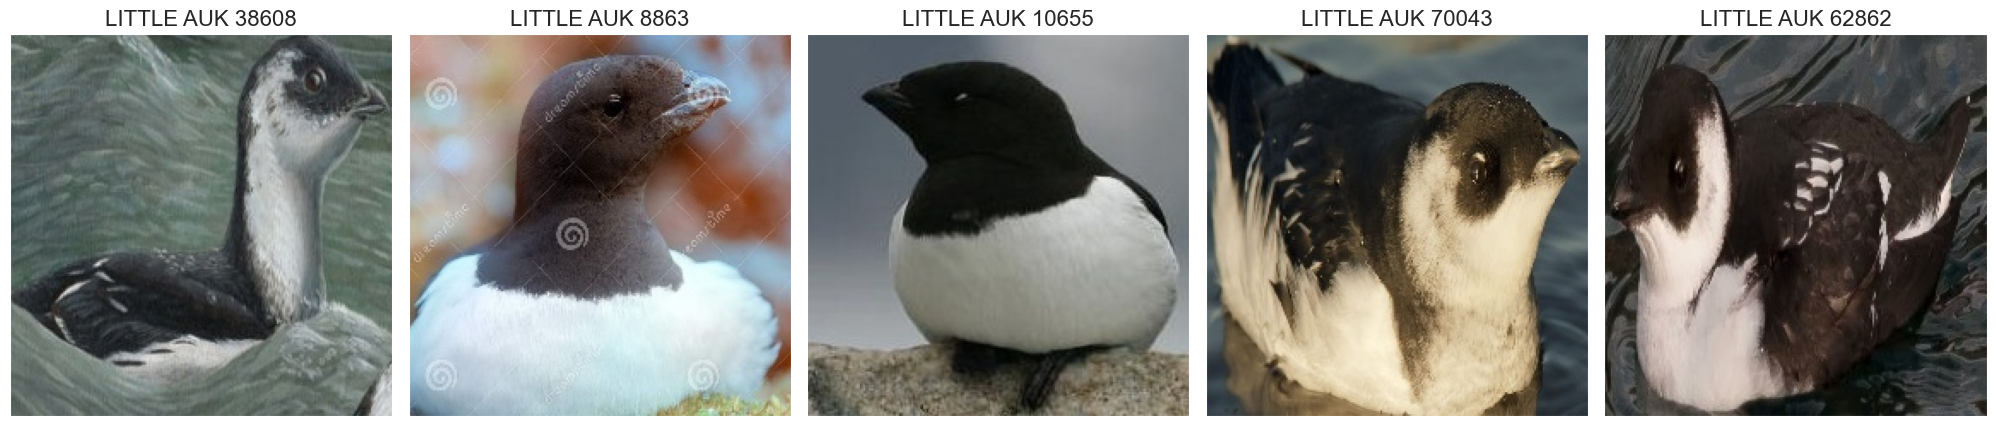

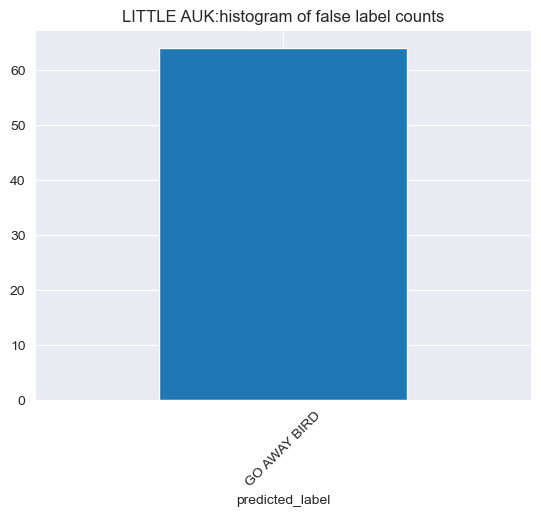

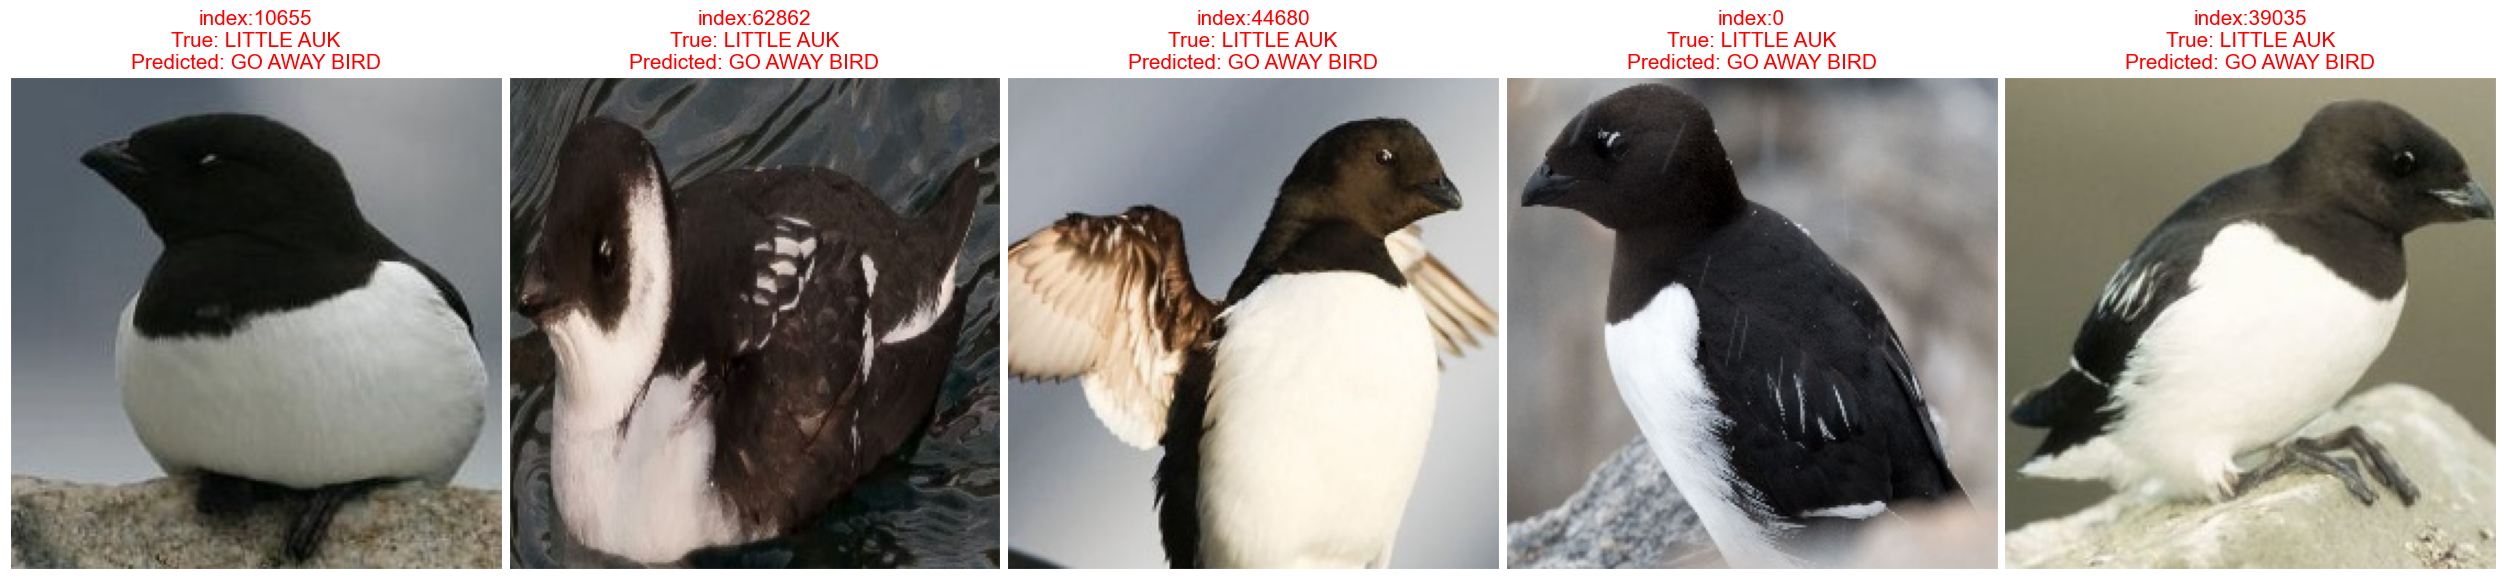

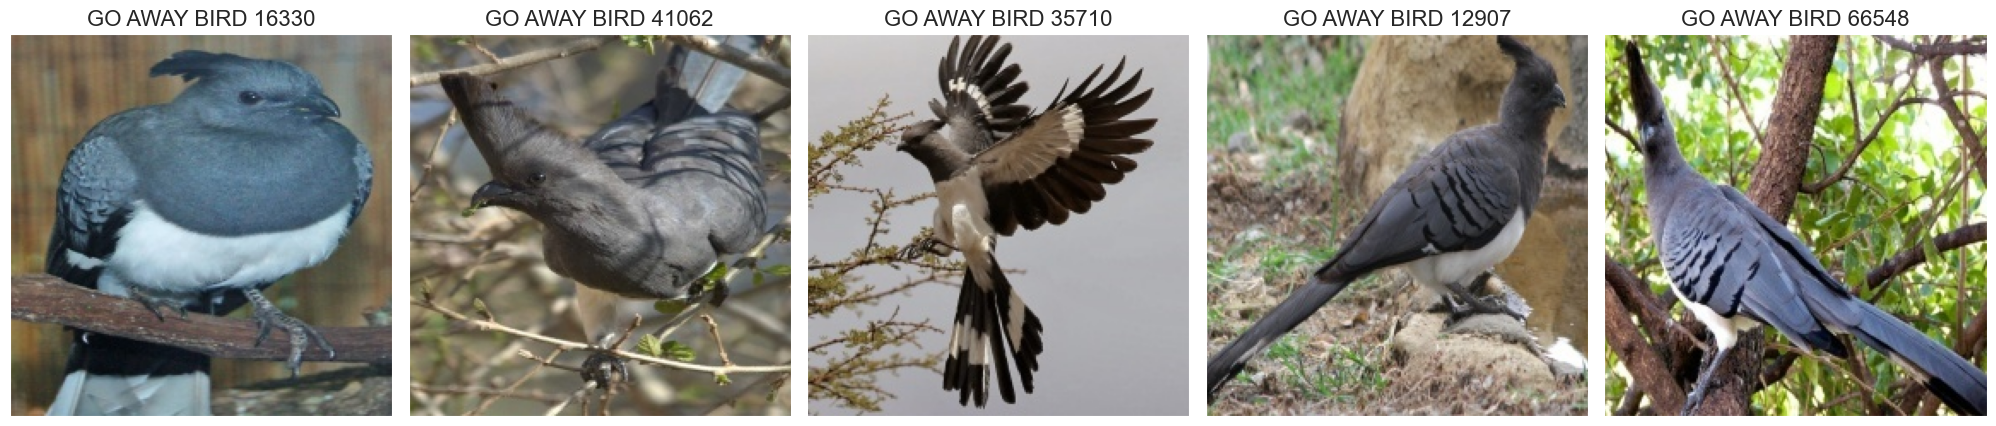

In [149]:
birds.plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=0,n_cols=5,N=5,false_ind=0,false_label = None)
birds.plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=1,n_cols=5,N=5,false_ind=0,false_label = None)

In [150]:
obj_dic_stack['train']['classification_report']

precision    recall  f1-score  support  accuracy
GO AWAY BIRD   0.457627  0.600000  0.519231     90.0  0.600000
LITTLE AUK     0.600000  0.457627  0.519231    118.0  0.457627

# Inserting None-Bird images

## get the other_df and put in the test structure

In [151]:
# filter from the image_df all the images with 'other' in the path
other_df = birds.get_other_images(image_df_full)

## Resizing 'others' images

In [152]:
from PIL import Image
def resize_image(input_path, output_path, new_size):
    # Open the image file
    original_image = Image.open(input_path)

    # Resize the image
    resized_image = original_image.resize(new_size)

    # Save the resized image to the specified output path
    resized_image.save(output_path)

# Example usage:
input_image_path = "path/to/your/input/image.jpg"
output_image_path = "path/to/your/output/resized_image.jpg"

input_path = './data/other/stuff/2.png'
output_path = './data/other/stuff/2.png'

resize_image(input_path, output_path, TARGET_SIZE)


FileNotFoundError: [Errno 2] No such file or directory: './data/other/stuff/2.png'

## Apply model on 'others' images

In [ ]:
others_obj_dic = {}

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

others_obj_dic['name'] = 'others'
others_obj_dic['df'] = birds.get_other_images(image_df_full)
others_obj_dic['images_obj'] = test_generator.flow_from_dataframe(
    dataframe=others_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

others_obj_dic = birds.apply_model(model,labels_dic,others_obj_dic,evaluate=False,plot_report=False)


Found 16 validated image filenames belonging to 2 classes.


--------------------------------
  apply model on others
--------------------------------
1/1 [==============================] - 1s 1s/step
       precision  recall  f1-score  support  accuracy
stuff        0.0     0.0       0.0      2.0       0.0
gilad        0.0     0.0       0.0     14.0       0.0


c:\gilad\courses\AI course\final_project\birds\birds_utils.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_dic['df']['predicted_label'] = pred
c:\gilad\courses\AI course\final_project\birds\birds_utils.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_dic['df']['status'] = obj_dic['df']['predicted_label']==obj_dic['df']['label']
c:\gilad\courses\AI course\final_project\birds\birds_utils.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [ ]:
others_obj_dic['df']

Filepath  label             predicted_label  \
5       data\other\gilad\DSC05386.JPG  gilad              GREAT KISKADEE   
13      data\other\gilad\DSC_5372.JPG  gilad    CHINESE BAMBOO PARTRIDGE   
179798         data\other\stuff\1.png  stuff       BLACK FACED SPOONBILL   
12      data\other\gilad\DSC_4751.jpg  gilad              GREAT KISKADEE   
10      data\other\gilad\DSC08895.jpg  gilad                      PUFFIN   
2       data\other\gilad\DSC03727.JPG  gilad     GREATER PRAIRIE CHICKEN   
0       data\other\gilad\DSC03161.JPG  gilad                     PEACOCK   
7       data\other\gilad\DSC07567.JPG  gilad             ARARIPE MANAKIN   
6       data\other\gilad\DSC06835.JPG  gilad          BLACK NECKED STILT   
11      data\other\gilad\DSC_1738.JPG  gilad           ROUGH LEG BUZZARD   
3       data\other\gilad\DSC04516.JPG  gilad                    OVENBIRD   
1       data\other\gilad\DSC03716.JPG  gilad              GREAT KISKADEE   
179799         data\other\stuff\2.png  stuff  BLACK AND YELLOW BROADBILL   
8       data\other\gilad\DSC07946.jpg  gilad              RUDDY SHELDUCK   
4       data\other\gilad\DSC04518.JPG  gilad                    OVENBIRD   
9       data\other\gilad\DSC08254.JPG  gilad                     PEACOCK   

        status     proba  
5        False  0.283788  
13       False  0.082764  
179798   False  0.193175  
12       False  0.126949  
10       False  0.150558  
2        False  0.030136  
0        False  0.116320  
7        False  0.095105  
6        False  0.210402  
11       False  0.336656  
3        False  0.097983  
1        False  0.073756  
179799   False  0.413604  
8        False  0.098387  
4        False  0.105984  
9        False  0.300176

## Some plotting of 'others' predictions

Plot the images of the 'stuff' df and their preditions

In [ ]:

# get the images of gilad predicted as 'LOONEY BIRDS'
df = others_obj_dic['df']
idx = df[(df['label'] == 'gilad') & (df['predicted_label'] == 'LOONEY BIRDS')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=4)

# get the images of gilad predicted as other birds
idx = df[(df['label'] == 'gilad') & (df['predicted_label'] == 'AMERICAN FLAMINGO')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)

idx = df[(df['label'] == 'gilad') & (df['predicted_label'] == 'TRUMPTER SWAN')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)

# get the images of stuff predicted as 'LOONEY BIRDS'
idx = df[(df['label'] == 'stuff') & (df['predicted_label'] == 'LOONEY BIRDS')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)

# get the images of stuff predicted as 'LOONEY BIRDS'
idx = df[(df['label'] == 'stuff') & (df['predicted_label'] == 'TRUMPTER SWAN')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)


ValueError: Number of rows must be a positive integer, not 0

<Figure size 2500x200 with 0 Axes>

Plot some images of the wrong predicted labels

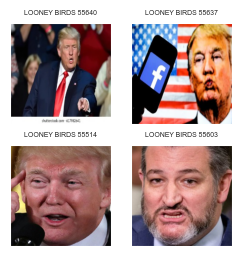

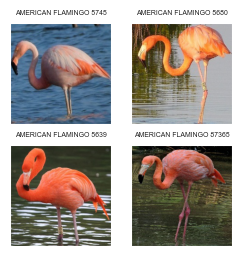

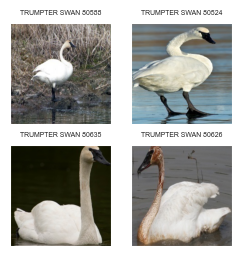

In [ ]:
birds.plot_label_images(image_df,label='LOONEY BIRDS',N=4,n_cols=2,fig_width=2.5)
birds.plot_label_images(image_df,label='AMERICAN FLAMINGO',N=4,n_cols=2,fig_width=2.5)
birds.plot_label_images(image_df,label='TRUMPTER SWAN',N=4,n_cols=2,fig_width=2.5)

# anomaly detection

In [ ]:
pred_proba_train = np.sort(obj_dic_stack['train']['pred_proba'],axis=1)
pred_proba_other = np.sort(others_obj_dic['pred_proba'],axis=1)



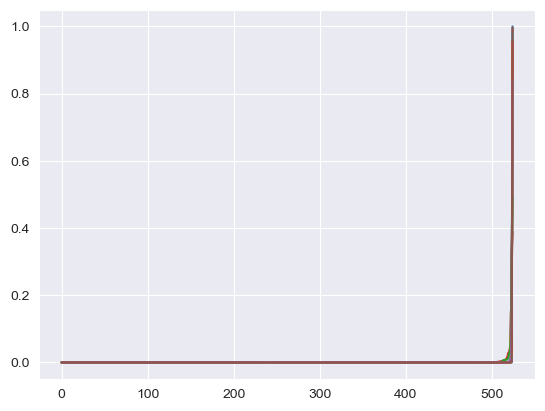

In [ ]:
plt.plot(pred_proba_other.T)

(0.0, 1.0)

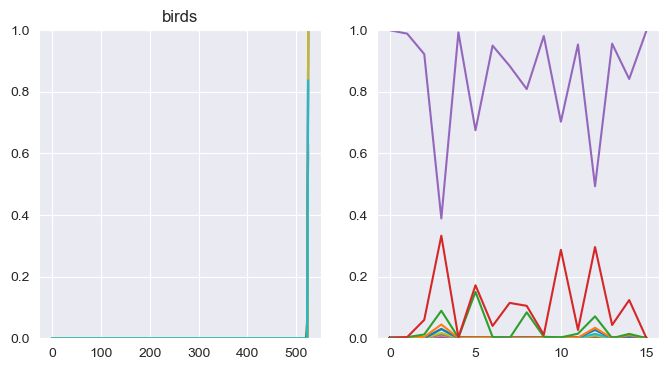

In [ ]:
birds_inx = np.random.randint(1, 3001, size=10)
others_inx = np.arange(-1,-11,-1)

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
for idx in birds_inx:
    plt.plot(pred_proba_train[idx,:])
plt.title('birds')
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(pred_proba_other[:])
# for idx in others_inx:
#     plt.plot(pred_proba_other[:])
# plt.title('none-birds')
plt.ylim([0,1])


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


isf = IsolationForest(contamination=0.01)
isf.fit(pred_proba_train)

is_not_bird = np.zeros(pred_proba.shape[0], dtype=bool)
for idx in range(pred_proba.shape[0]):
    is_not_bird[idx] = (isf.predict(pred_proba[idx,:].reshape(1,-1))==-1)

ind_vec = np.where(is_not_bird)[0]


NameError: name 'pred_proba' is not defined

In [ ]:
ind_vec
none_bird_idx = list(test_obj_dic['df'].index[ind_vec])

In [ ]:
test_obj_dic['df'].loc[87166]

In [ ]:
x_values = np.arange(1, 101)
selected_rows = ind_vec
for row_idx in selected_rows:
    line_values = pred_proba[row_idx, :]
    plt.plot(line_values, label=f'Row {row_idx}')

plt.legend(none_bird_idx)

birds.plot_images(test_obj_dic['df'],idx=test_obj_dic['df'].iloc[np.where(is_not_bird)].index)

# ☀️Grad-Cam Visualization

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [ ]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model


    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])

    with tf.GradientTape() as tape:
  # cast the image tensor to a float-32 data type, pass the
  # image through the gradient model, and grab the loss
  # associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]

		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):

    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.


    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

In [ ]:
from random import shuffle
from tqdm import tqdm


def label_image_one_hot_encoder(img):
  ## Helper for process_data
  label = img.split('_')[0]
  if label == 'cat': return 0
  elif label == 'dog': return 1


def process_data(image_list, DATA_FOLDER, IMG_SIZE):
  ## Helper for manual_pre_process
  ## Creates an array of images, labels, and file path
  ## Shuffles the array before returning
  data_df = []
  for img in tqdm(image_list):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image_one_hot_encoder(img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data_df.append([np.array(img), np.array(label), path])
  shuffle(data_df)
  return data_df


def manual_pre_process(dir, IMG_SIZE):
  '''
  Creates an array of images, labels, and files from a directory of image files

  Args:
    dir: string, folder name
    IMG_SIZE: int, image height and width

  Returns
    X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
    y: (n,) numpy array of labels
    files: (n,) numpy array of files

  '''
  image_lst = os.listdir(dir)
  data_df = process_data(image_lst, dir, IMG_SIZE)
  X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y = np.array([i[1] for i in data_df])
  files = np.array([i[2] for i in data_df])
  return X, y, files

val_imgs = './data/test/ABBOTTS BABBLER'
class_info = birds.load_var('labels_dic.pkl')
X, y, files = manual_pre_process(val_imgs, 224)

img = X[0]
label = y[0]
path = files[0]

could not open labels_dic.pkl for reading


100%|██████████| 5/5 [00:00<00:00, 469.49it/s]


In [ ]:
layer_name = 'top_conv'
img_array = np.expand_dims(img, axis=0)
eps=1e-8
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)

In [ ]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()


In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
obj_dic = val_obj_dic
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
random_index = np.random.randint(0, len(obj_dic['df']) - 1, 15)

for i, ax in enumerate(axes.flat):
    img_path = obj_dic['df'].Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    # ax.set_title(f"True: {obj_dic['df'].label.iloc[random_index[i]]}\nPredicted: {obj_dic['df'].predicted_label.iloc[random_index[i]]}")
plt.tight_layout()
plt.show()

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s'
     height=30px width=160px /></center>